# Train WaveNet

In [1]:
from wavenet_model import WaveNetModel
from wavenet_training import AudioFileLoader, WaveNetOptimizer

import torch
import numpy as np
import time

from IPython.display import Audio
from matplotlib import pyplot as plt
from matplotlib import pylab as pl
from IPython import display

%matplotlib notebook

## Setup Model

In [2]:
train_samples = ["train_samples/bach_full.wav"]
sampling_rate = 11025
init_model = None

layers = 10
blocks = 3
classes = 256
dilation_channels = 32
residual_channels = 32
skip_channels = 64
kernel_size = 2
dtype = torch.FloatTensor
ltype = torch.LongTensor

use_cuda = torch.cuda.is_available()
if use_cuda:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor

In [3]:
model = WaveNetModel(layers=layers,
                     blocks=blocks,
                     dilation_channels=dilation_channels,
                     residual_channels=residual_channels,
                     skip_channels=skip_channels,
                     classes=classes,
                     kernel_size=kernel_size,
                     dtype=dtype)

if use_cuda:
    model.cuda()
    print("use cuda")

#print("model: ", model)
print("receptive_field: ", model.receptive_field)
print("parameter count: ", model.parameter_count())

if init_model != None:
    if use_cuda:
        model.load_state_dict(torch.load(init_model))
    else:
        # move to cpu
        model.load_state_dict(torch.load(init_model, map_location=lambda storage, loc: storage))

data_loader = AudioFileLoader(train_samples,
                              classes=classes,
                              max_load_duration=600.,
                              dtype=dtype,
                              ltype=ltype,
                              sampling_rate=sampling_rate)

receptive_field:  3581
parameter count:  170272
total duration of training data:  141.374693877551  s


In [4]:
data_loader.start_new_epoch()
start_data = data_loader.get_wavenet_minibatch([model.receptive_field], 
                                               model.receptive_field,
                                               model.output_length)[0]
start_data = start_data.squeeze()

plt.ion()
plt.plot(start_data[-200:].numpy())
plt.ioff()

new epoch
load new chunk
data from  train_samples/bach_full.wav
load new chunk
data from  train_samples/bach_full.wav


<IPython.core.display.Javascript object>

## Train Model

In [9]:
learning_rate = 0.001
mini_batch_size = 4
avg_length = 4
epochs = 20
model_path = "model_parameters/bach_10-5-256-32-32-256-2"

In [10]:
def report_callback(losses):
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()

optimizer = WaveNetOptimizer(model,
                             mini_batch_size=mini_batch_size,
                             report_length=avg_length,
                             report_callback=report_callback)

<IPython.core.display.Javascript object>


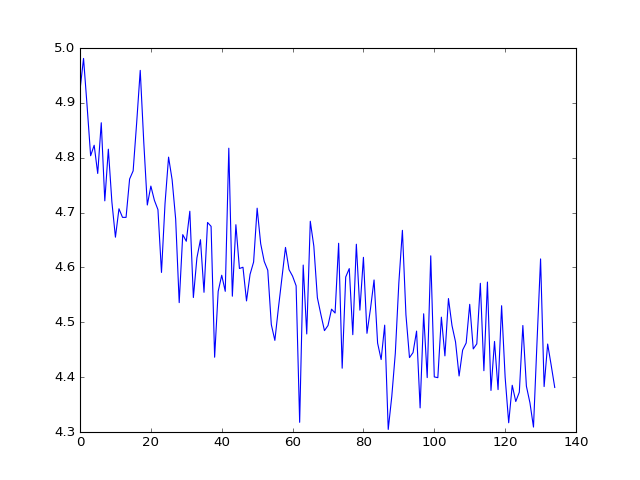

start training...
new epoch
load new chunk
data from  train_samples/bach_full.wav
load new chunk
data from  train_samples/bach_full.wav
epoch  0
snapshot saved to  model_parameters/bach_10-5-256-32-32-256-2
snapshot saved to  model_parameters/bach_10-5-256-32-32-256-2


KeyboardInterrupt: 

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

print('start training...')
tic = time.time()
optimizer.train(data_loader, 
                epochs=epochs,
                snapshot_interval=300,
                snapshot_file=model_path)
toc = time.time()
print('Training took {} seconds.'.format(toc-tic))

In [ ]:
torch.save(model.state_dict(), model_path)